No gemflag is provided, assuming the model includes biogem and ecogem
No gemflag is provided, assuming the model includes biogem and ecogem
No gemflag is provided, assuming the model includes biogem and ecogem


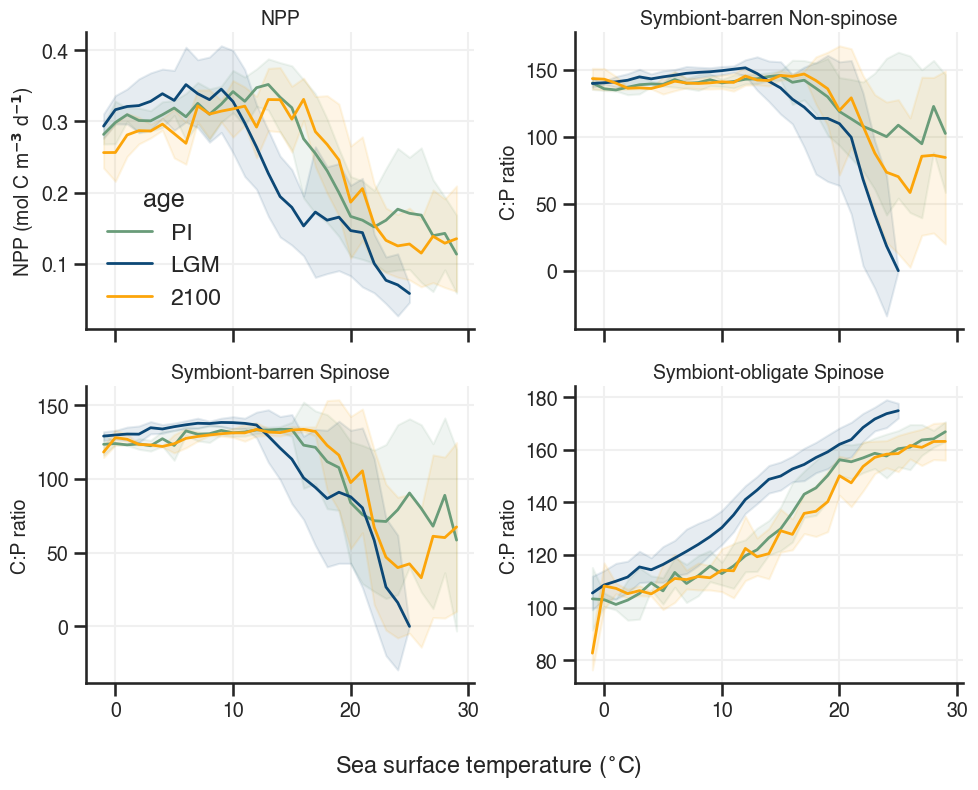

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from cgeniepy.ecology import EcoModel

colors = ["#699c79", "#0C4876"]
sst_bins = range(-1, 30)

## bin a model data according to SST
def bin_variable(model, variable, age_label, bin_res=1):
    values = model.get_var(variable).isel(time=-1).array.values.flatten()
    sst = model.get_var('ocn_sur_temp').isel(time=-1).array.values.flatten()
    bins = range(-1, 30, bin_res)
    
    values_binned = [values[(sst >= b) & (sst < b + 1)] for b in bins]
    
    ## merge into dataframes
    df = pd.DataFrame({'sst': bins, 'age': age_label, variable: values_binned})
    return df

def bin_stoichiometry(model, foram, age_label, bin_res=1):
    c = model.get_foram(foram, 'Biomass', "C").isel(time=-1).array.values.flatten()
    p = model.get_foram(foram, 'Biomass', "P").isel(time=-1).array.values.flatten()
    sst = model.get_var('ocn_sur_temp').isel(time=-1).array.values.flatten()
    bins = range(-1, 30, bin_res)
    
    c_to_p = c / p
    c_to_p_binned = [c_to_p[(sst >= b) & (sst < b + 1)] for b in bins]
    
    ## merge into dataframes
    df = pd.DataFrame({'sst': bins, 'age':age_label, 'stoichiometry': c_to_p_binned})
    
    return df

def bin_ensemble_variable(models,variable,model_label):
    df_list = []
    for i, model in enumerate(models):
        df_list.append(bin_variable(model, variable, model_label[i]).explode(variable))    
    
    ## merge into dataframes
    df = pd.concat(df_list)
    df_long = pd.melt(df, id_vars=['sst', 'age'], 
                      value_vars=[variable], 
                      var_name='variable',
                      value_name='value')

    return df_long

def bin_ensemble_stoichiometry(models,foram,model_label):
    df_list = []
    for i, model in enumerate(models):
        df_list.append(bin_stoichiometry(model, foram, model_label[i]).explode('stoichiometry'))

        ## merge into dataframes
    df = pd.concat(df_list)
    df_long = pd.melt(df, id_vars=['sst', 'age'],
                      value_vars=['stoichiometry'],
                      var_name='variable',
                      value_name='value')

    return df_long

pi_model = EcoModel('../model/muffin.CBE.worlg4.BASESFeTDTL.diag')
future_model = EcoModel('../model/muffin.CBE.worlg4.BASESFeTDTL.2100.4deg')
lgm_model = EcoModel('../model/muffin.CBE.GIteiiva.BASESFeTDTL_rb.diag')

model_list = [pi_model, lgm_model, future_model]
model_label = ['PI', 'LGM', '2100']

d1 = bin_ensemble_variable(model_list, 'eco2D_Uptake_Fluxes_C', model_label)
d2 = bin_ensemble_stoichiometry(model_list, 'bn', model_label)
d3 = bin_ensemble_stoichiometry(model_list, 'bs', model_label)
d4 = bin_ensemble_stoichiometry(model_list, 'ss', model_label)

## plot in one figure
import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize=(10, 8), nrows=2, ncols=2, sharex=True, tight_layout=True)

## plot using seaborn
def set_publication_theme(base_size=14, base_family="helvetica"):

    custom_params = {
        "axes.spines.right": False,
        "axes.spines.top": False,
        "axes.grid": True,
        "grid.color": "#f0f0f0",
        "grid.linewidth": 1.5,
        'lines.linewidth': 2,
        'legend.frameon': False,
        'legend.loc': 'lower left',

    }

    sns.set_theme(context='talk', style='ticks', font=base_family, rc=custom_params)


    font = {
        'family': base_family,
        'weight': 'bold',
        'size': base_size
    }

    plt.rc('font', **font)

    params = {
        'axes.labelsize': base_size,
        'axes.titlesize': base_size,
        'xtick.labelsize': base_size,
        'ytick.labelsize': base_size
    }
    plt.rcParams.update(params)

set_publication_theme()

colors = ["#699c79", "#0C4876", "#fca50a"]
fig.supxlabel('Sea surface temperature ($^{\circ}$C)')

axs[0, 0].set_ylabel('NPP (mol C m$^{-3}$ d$^{-1}$)')
axs[0, 0].set_title('NPP')

axs[0, 1].set_ylabel('C:P ratio')
axs[0, 1].set_title('Symbiont-barren Non-spinose')

axs[1, 0].set_ylabel('C:P ratio')
axs[1, 0].set_title('Symbiont-barren Spinose')
axs[1, 0].set_ylabel('C:P ratio')

axs[1, 1].set_ylabel('C:P ratio')
axs[1, 1].set_title('Symbiont-obligate Spinose')
axs[1, 1].set_ylabel('C:P ratio')

sns.lineplot(data=d1, x='sst', y='value', hue='age', errorbar='sd',
             palette=colors, ax=axs[0, 0], err_kws={'alpha': 0.1})
sns.lineplot(data=d2, x='sst', y='value', hue='age', errorbar='sd',
             palette=colors, ax=axs[0, 1], legend=False, err_kws={'alpha': 0.1})
sns.lineplot(data=d3, x='sst', y='value', hue='age', errorbar='sd',
              palette=colors, ax=axs[1, 0], legend=False, err_kws={'alpha': 0.1})
sns.lineplot(data=d4, x='sst', y='value', hue='age', errorbar='sd',
                palette=colors, ax=axs[1, 1], legend=False,err_kws={'alpha': 0.1})

## remove all x axis label
for ax in axs.flatten():
    ax.xaxis.label.set_visible(False)
    
## save to figure
fig.savefig('../output/fig4.png', dpi=300, bbox_inches='tight')

In [106]:
def diagnose_foram_rate(model, foram, variable):
    c = model.get_foram(foram, 'Biomass', "C").isel(time=-1)
    sst = model.get_var('ocn_sur_temp').isel(time=-1)

    try:
        v = model.get_foram(foram, variable, "C").isel(time=-1)        
        rate = v/c
        df = pd.DataFrame({'sst': sst.array.values.flatten(), variable: rate.array.values.flatten()})
    except ValueError:
        df = pd.DataFrame({'sst': sst.array.values.flatten(), variable: 0})
    ## drop nan
    df = df.dropna()
    return df

## auto uptake, grazing uptake, respiration, mortality
#fig, axs = plt.subplots(figsize=(12, 6), nrows=3, ncols=5, sharex=True, tight_layout=True)


forams = ['bn', 'bs', 'ss']
model_list = [pi_model, lgm_model, future_model]
rate_vars = ['HeteroUptake','AutoUptake', 'Mortality', 'Respiration','Eaten']
colors = ["#699c79", "#0C4876", "#fca50a"]

a = diagnose_foram_rate(pi_model, 'ss','AutoUptake')
b= diagnose_foram_rate(pi_model, 'ss','HeteroUptake')
c = diagnose_foram_rate(pi_model, 'ss','Mortality')
d = diagnose_foram_rate(pi_model, 'ss','Respiration')
e = diagnose_foram_rate(pi_model, 'ss','Eaten')

## merge into one dataframe based on same index
df = pd.merge(a, b, on='sst', how='outer').merge(c, on='sst', how='outer').merge(d, on='sst', how='outer').merge(e, on='sst', how='outer')
df['Mortality'] = df['Mortality'] * -1
df['Respiration'] = df['Respiration'] * -1
df['Eaten'] = df['Eaten'] * -1

## get a histogram plot of the rates
df['in'] = df['HeteroUptake'] + df['AutoUptake']
df['out'] = df['Mortality'] + df['Respiration'] + df['Eaten']
df['net'] = df['in'] + df['out']

bin_size = 1  # Define the bin size
df['sst_bin'] = (df['sst'] // bin_size) * bin_size  # Creating a new column for bins

#df.plot(kind='line', y='net', x='sst_bin')
df

,sst,AutoUptake,HeteroUptake,Mortality,Respiration,Eaten,in,out,net,sst_bin
0,-1.833192,0.017435,0.013831,-0.015743,-0.015110,-7.379832e-13,0.031266,-0.030853,0.000413,-2.0
1,-1.642349,0.017438,0.013015,-0.015008,-0.015316,-5.518448e-13,0.030452,-0.030324,0.000128,-2.0
2,-1.461325,0.017639,0.012455,-0.014318,-0.015509,-3.717238e-13,0.030095,-0.029827,0.000268,-2.0
3,-1.290279,0.017036,0.011362,-0.012254,-0.015693,-1.989526e-13,0.028398,-0.027947,0.000451,-2.0
4,-1.163031,0.018959,0.016159,-0.019095,-0.015781,-1.572692e-12,0.035118,-0.034876,0.000242,-2.0
...,...,...,...,...,...,...,...,...,...,...
931,-1.102998,0.017846,0.011267,-0.012540,-0.016198,-2.216537e-13,0.029113,-0.028738,0.000375,-2.0
932,-1.099021,0.017871,0.011085,-0.012179,-0.016206,-2.068570e-13,0.028955,-0.028385,0.000571,-2.0
933,-1.100149,0.017846,0.011483,-0.012759,-0.016210,-2.304099e-13,0.029330,-0.028969,0.000361,-2.0
934,-1.104215,0.017838,0.011626,-0.012881,-0.016207,-2.342986e-13,0.029464,-0.029088,0.000376,-2.0


<Axes: xlabel='sst', ylabel='net'>

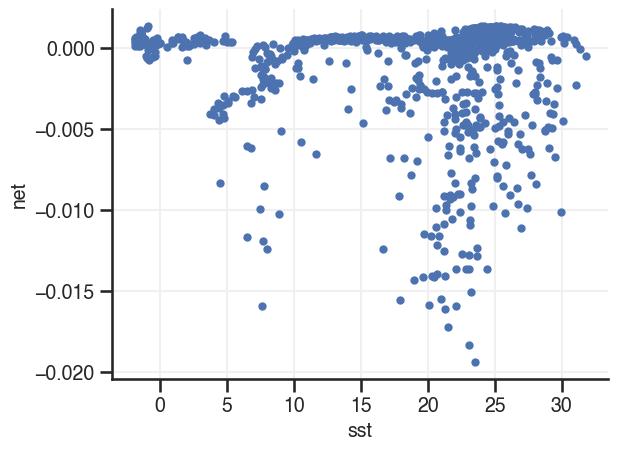

<Axes: xlabel='sst_bin'>

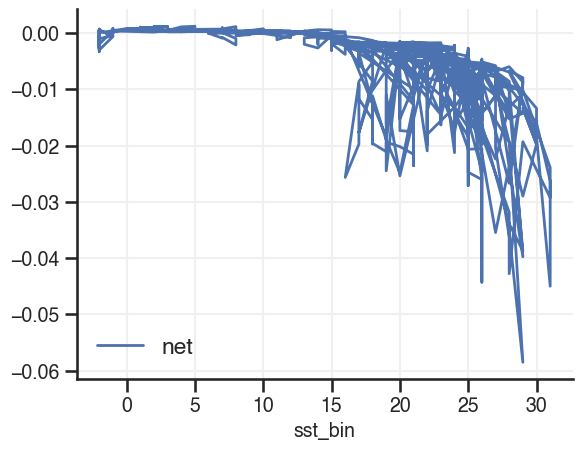

<Axes: xlabel='sst', ylabel='value'>

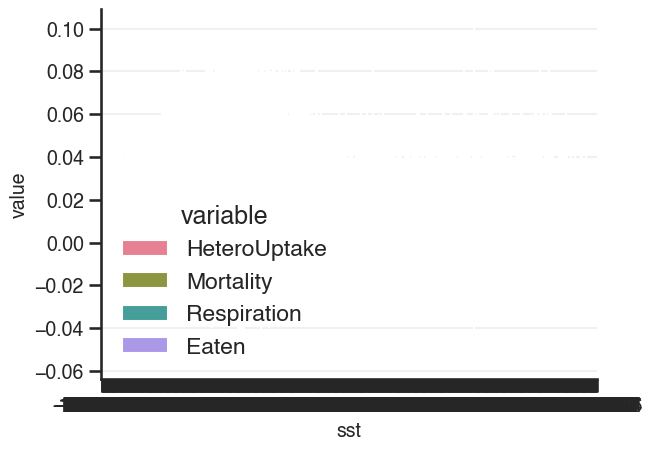

In [70]:

## plot up-down histogram
import seaborn as sns
## make data into long format
df = pd.melt(df, id_vars=['sst'], 
             value_vars=['HeteroUptake', 'Mortality', 'Respiration','Eaten'], 
             var_name='variable',
             value_name='value')
## plot composition over sst




<Axes: xlabel='sst_bin', ylabel='value'>

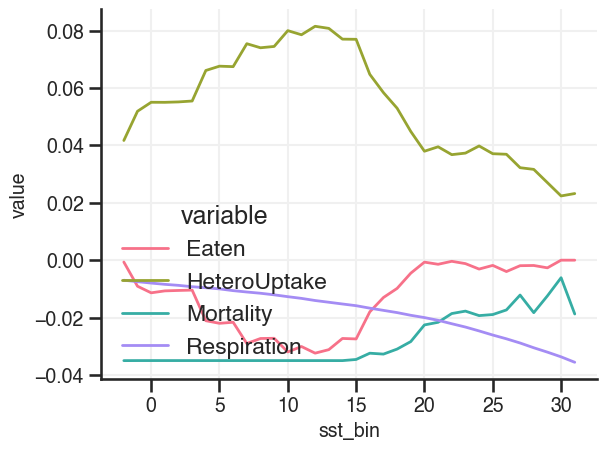

In [78]:

# Binning and taking the mean
binned_data = df.groupby(['sst_bin', 'variable']).mean().reset_index()
sns.lineplot(x='sst_bin', y='value', hue='variable', data=binned_data, palette='husl')

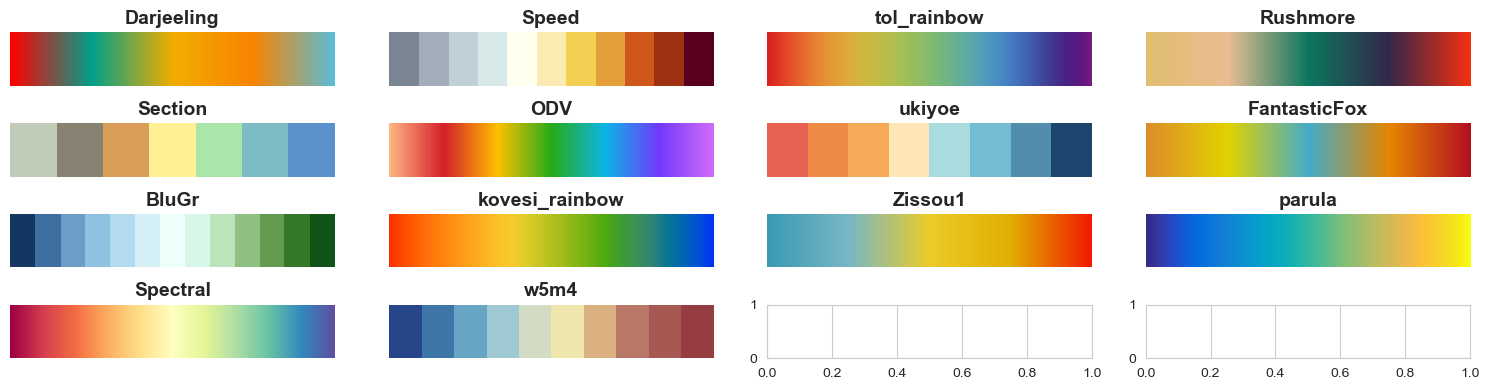

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cgeniepy.plot import os_cmap, avail_cmaps

# List of colormaps from cgeniepy
cmaps_list = avail_cmaps()

def plot_colormaps(cmaps):
    ncols = 4
    nrows = int(np.ceil(len(cmaps) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows))

    for i, cmap_name in enumerate(cmaps):
        row = i // ncols
        col = i % ncols
        ax = axes[row, col] if nrows > 1 else axes[col]

        # Create a gradient image using the colormap
        gradient = np.linspace(0, 1, 256).reshape(1, -1)
        ax.imshow(gradient, aspect='auto', cmap=os_cmap(cmap_name))
        ax.set_title(cmap_name, fontsize=14, fontweight='bold')
        ax.axis('off')

    plt.tight_layout()
    plt.savefig('/Users/yingrui/Downloads/open_cmaps.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_colormaps(cmaps_list)